<a href="https://colab.research.google.com/github/SergeySmalkov/Detector/blob/main/Perudo_Binance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from IPython.core.display import display, HTML
from scipy import signal
from numba import jit
from datetime import timedelta
from bisect import bisect_left
pd.set_option('mode.chained_assignment', None)
from math import exp


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
binance = pd.read_pickle('drive/MyDrive/crypto_research/binance')
t1 = '2023-06-13 01:00:00.259'
t2 = '2023-06-13 23:55:23.259'
binance = binance[(binance['receive_timestamp'] > t1) & (binance['receive_timestamp'] < t2)]

binance_trades = pd.read_pickle('drive/MyDrive/crypto_research/trades_Binance')
binance_trades = binance_trades[(binance_trades['receive_timestamp'] > t1) & (binance_trades['receive_timestamp'] < t2)]
binance_trades

,market,outer_id,symbol,price,amount,maker_side,market_timestamp,receive_timestamp
5752,Binance,364483852,SOLUSDT,15.07,19.00,Bid,2023-06-13 01:00:01.579,2023-06-13 01:00:01.710
5753,Binance,364483853,SOLUSDT,15.07,0.67,Bid,2023-06-13 01:00:01.579,2023-06-13 01:00:01.710
5754,Binance,364483854,SOLUSDT,15.06,2.70,Bid,2023-06-13 01:00:04.437,2023-06-13 01:00:04.567
5755,Binance,364483855,SOLUSDT,15.06,1.59,Bid,2023-06-13 01:00:04.437,2023-06-13 01:00:04.568
5756,Binance,364483856,SOLUSDT,15.06,35.48,Bid,2023-06-13 01:00:04.437,2023-06-13 01:00:04.568
...,...,...,...,...,...,...,...,...
137274,Binance,364615377,SOLUSDT,15.01,0.49,Bid,2023-06-13 23:55:08.328,2023-06-13 23:55:08.459
137275,Binance,364615378,SOLUSDT,15.01,4.88,Ask,2023-06-13 23:55:10.445,2023-06-13 23:55:10.575
137276,Binance,364615379,SOLUSDT,15.01,0.73,Ask,2023-06-13 23:55:12.485,2023-06-13 23:55:12.614
137277,Binance,364615380,SOLUSDT,15.01,4.11,Ask,2023-06-13 23:55:13.533,2023-06-13 23:55:13.663


In [27]:
# Function to get the best bid
def get_best_bid(bids):
    # The best bid is the highest price in the bids list
    # Bids list is formatted as [(price, volume),...]
    # So, we sort by price in descending order and take the first element
    best_bid = sorted(bids, key=lambda x: x[0], reverse=True)[0][0]
    return best_bid

# Function to get the best ask
def get_best_ask(asks):
    # The best ask is the lowest price in the asks list
    # Asks list is formatted as [(price, volume),...]
    # So, we sort by price in ascending order and take the first element
    best_ask = sorted(asks, key=lambda x: x[0])[0][0]
    return best_ask

# Apply these functions to your DataFrame
binance['best_bid'] = binance['bids'].apply(get_best_bid)
binance['best_ask'] = binance['asks'].apply(get_best_ask)

# The mid point of ToB is the average of the best bid and best ask
binance['mid_ToB'] = (binance['best_bid'] + binance['best_ask']) / 2
binance = binance.drop(['symbol', 'market'], axis=1)
binance



,receive_timestamp,asks,bids,best_bid,best_ask,mid_ToB
18445,2023-06-13 01:00:00.359,"[(15.08, 3813.08), (15.09, 4533.26), (15.1, 75...","[(15.07, 19.67), (15.06, 5778.61), (15.05, 655...",15.07,15.08,15.075
18446,2023-06-13 01:00:00.458,"[(15.08, 5052.75), (15.09, 4496.04), (15.1, 70...","[(15.07, 19.67), (15.06, 5794.91), (15.05, 625...",15.07,15.08,15.075
18447,2023-06-13 01:00:00.557,"[(15.08, 5470.02), (15.09, 3921.5), (15.1, 699...","[(15.07, 19.67), (15.06, 5514.91), (15.05, 602...",15.07,15.08,15.075
18448,2023-06-13 01:00:00.659,"[(15.08, 5752.02), (15.09, 5763.56), (15.1, 87...","[(15.07, 19.67), (15.06, 3028.08), (15.05, 808...",15.07,15.08,15.075
18449,2023-06-13 01:00:00.756,"[(15.08, 5752.02), (15.09, 5763.56), (15.1, 87...","[(15.07, 19.67), (15.06, 3028.08), (15.05, 804...",15.07,15.08,15.075
...,...,...,...,...,...,...
426185,2023-06-13 23:55:21.633,"[(15.01, 1795.64), (15.02, 3117.88), (15.03, 5...","[(15.0, 1670.93), (14.99, 2987.5), (14.98, 824...",15.00,15.01,15.005
426186,2023-06-13 23:55:22.033,"[(15.01, 1765.64), (15.02, 3117.88), (15.03, 5...","[(15.0, 1670.93), (14.99, 2987.5), (14.98, 824...",15.00,15.01,15.005
426187,2023-06-13 23:55:22.234,"[(15.01, 1765.64), (15.02, 3117.88), (15.03, 5...","[(15.0, 1670.93), (14.99, 2987.5), (14.98, 824...",15.00,15.01,15.005
426188,2023-06-13 23:55:22.634,"[(15.01, 1765.64), (15.02, 3117.88), (15.03, 5...","[(15.0, 1670.93), (14.99, 2987.5), (14.98, 824...",15.00,15.01,15.005


In [28]:
binance_trades = binance_trades.drop(['symbol', 'market', 'outer_id'], axis=1)
binance_trades

,price,amount,maker_side,market_timestamp,receive_timestamp
5752,15.07,19.00,Bid,2023-06-13 01:00:01.579,2023-06-13 01:00:01.710
5753,15.07,0.67,Bid,2023-06-13 01:00:01.579,2023-06-13 01:00:01.710
5754,15.06,2.70,Bid,2023-06-13 01:00:04.437,2023-06-13 01:00:04.567
5755,15.06,1.59,Bid,2023-06-13 01:00:04.437,2023-06-13 01:00:04.568
5756,15.06,35.48,Bid,2023-06-13 01:00:04.437,2023-06-13 01:00:04.568
...,...,...,...,...,...
137274,15.01,0.49,Bid,2023-06-13 23:55:08.328,2023-06-13 23:55:08.459
137275,15.01,4.88,Ask,2023-06-13 23:55:10.445,2023-06-13 23:55:10.575
137276,15.01,0.73,Ask,2023-06-13 23:55:12.485,2023-06-13 23:55:12.614
137277,15.01,4.11,Ask,2023-06-13 23:55:13.533,2023-06-13 23:55:13.663


In [29]:
# Ensure the 'receive_timestamp' and 'market_timestamp' columns are in datetime format
binance['receive_timestamp'] = pd.to_datetime(binance['receive_timestamp'])
binance_trades['receive_timestamp'] = pd.to_datetime(binance_trades['receive_timestamp'])

# Sort by timestamp
binance = binance.sort_values('receive_timestamp')
binance_trades = binance_trades.sort_values('receive_timestamp')

# Use merge_asof to find the last actual row from binance for each row in binance_trades
merged_df = pd.merge_asof(binance_trades, binance, left_on='receive_timestamp', right_on='receive_timestamp', direction='backward')

# Compute burst_lvl using vectorized operations
tick_size = 0.01
mask_ask = merged_df['maker_side'] == 'Ask'
mask_bid = merged_df['maker_side'] == 'Bid'

merged_df['burst_lvl'] = 0
merged_df.loc[mask_ask, 'burst_lvl'] = (merged_df['price'] - merged_df['best_ask']) / tick_size
merged_df.loc[mask_bid, 'burst_lvl'] = (merged_df['best_bid'] - merged_df['price']) / tick_size

# Drop the columns from binance table if needed, so you only have binance_trades columns and the new burst_lvl column
result_df = merged_df[binance_trades.columns.tolist() + ['burst_lvl']]
result_df = result_df.sort_values('receive_timestamp')
result_df['burst_lvl'] = result_df['burst_lvl'].round().astype(int)
result_df


,price,amount,maker_side,market_timestamp,receive_timestamp,burst_lvl
0,15.07,19.00,Bid,2023-06-13 01:00:01.579,2023-06-13 01:00:01.710,0
1,15.07,0.67,Bid,2023-06-13 01:00:01.579,2023-06-13 01:00:01.710,0
2,15.06,2.70,Bid,2023-06-13 01:00:04.437,2023-06-13 01:00:04.567,0
3,15.06,1.59,Bid,2023-06-13 01:00:04.437,2023-06-13 01:00:04.568,0
4,15.06,35.48,Bid,2023-06-13 01:00:04.437,2023-06-13 01:00:04.568,0
...,...,...,...,...,...,...
131522,15.01,0.49,Bid,2023-06-13 23:55:08.328,2023-06-13 23:55:08.459,0
131523,15.01,4.88,Ask,2023-06-13 23:55:10.445,2023-06-13 23:55:10.575,0
131524,15.01,0.73,Ask,2023-06-13 23:55:12.485,2023-06-13 23:55:12.614,0
131525,15.01,4.11,Ask,2023-06-13 23:55:13.533,2023-06-13 23:55:13.663,0


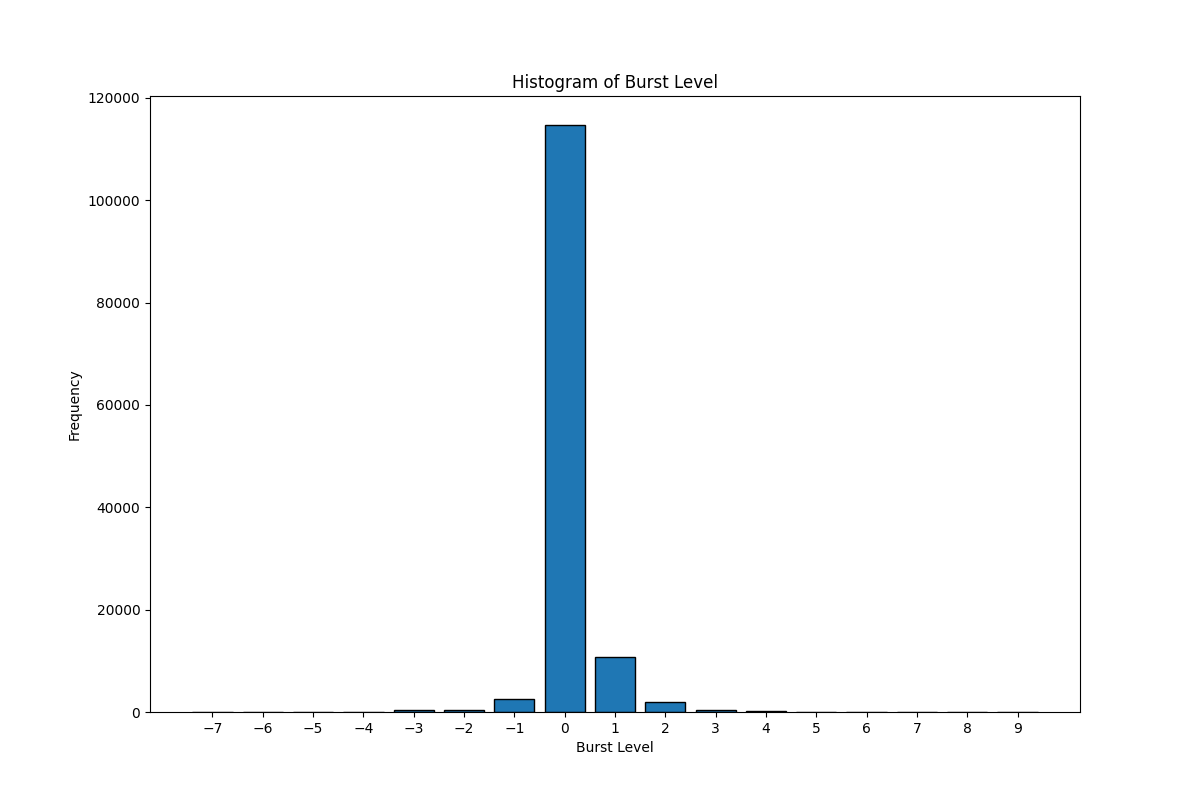

In [30]:
# Group data based on 'burst_lvl' and count occurrences
value_counts = result_df['burst_lvl'].value_counts()
# Sort by index (burst_lvl values) to maintain order
value_counts = value_counts.sort_index()
plt.close('all')
plt.figure(figsize=(12, 8))
# Create a bar plot
plt.bar(value_counts.index, value_counts.values, align='center', edgecolor='black')
plt.xlabel('Burst Level')
plt.ylabel('Frequency')
plt.title('Histogram of Burst Level')
# Set the x-axis labels to the index of value_counts
plt.xticks(value_counts.index)


plt.show()

In [31]:
result_df[result_df['burst_lvl'] == -7]

,price,amount,maker_side,market_timestamp,receive_timestamp,burst_lvl
56515,15.71,145.52,Bid,2023-06-13 12:30:01.259,2023-06-13 12:30:01.528,-7
56513,15.71,19.78,Bid,2023-06-13 12:30:01.259,2023-06-13 12:30:01.528,-7
56521,15.72,145.52,Bid,2023-06-13 12:30:01.457,2023-06-13 12:30:01.689,-7
113763,15.09,1.38,Bid,2023-06-13 18:17:32.770,2023-06-13 18:17:32.917,-7
113764,15.09,27.00,Bid,2023-06-13 18:17:32.772,2023-06-13 18:17:32.918,-7
113765,15.09,3.25,Bid,2023-06-13 18:17:32.774,2023-06-13 18:17:32.919,-7
113766,15.09,3.24,Bid,2023-06-13 18:17:32.777,2023-06-13 18:17:32.921,-7
113767,15.09,3.27,Bid,2023-06-13 18:17:32.778,2023-06-13 18:17:32.921,-7


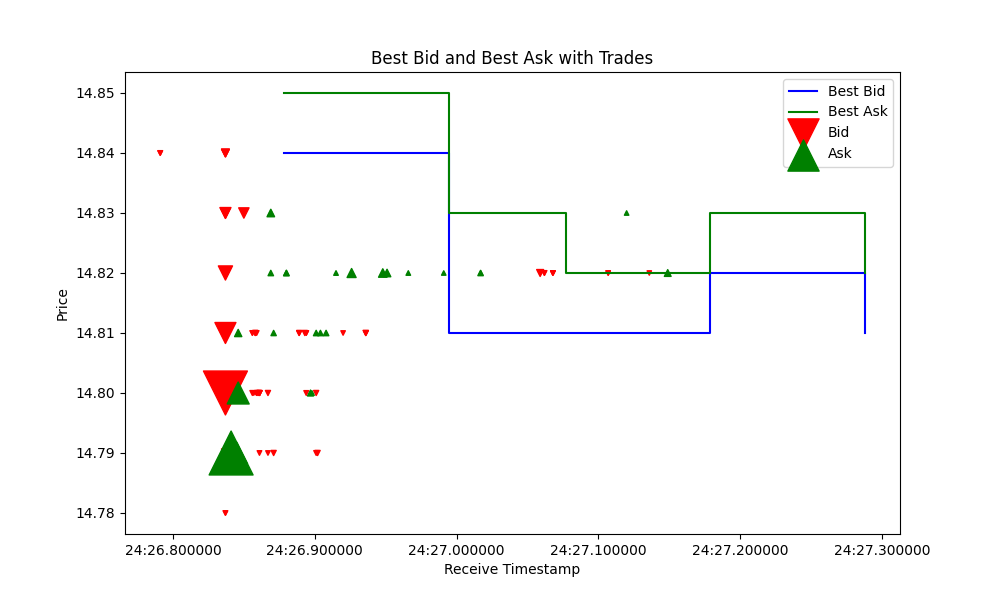

In [66]:
start_time = pd.to_datetime('2023-06-13 15:24:26.800')
end_time = pd.to_datetime('2023-06-13 15:24:27.300')

binance_filtered = binance[(binance['receive_timestamp'] >= start_time) & (binance['receive_timestamp'] <= end_time)]
binance_trades_filtered = binance_trades[(binance_trades['receive_timestamp'] >= start_time) & (binance_trades['receive_timestamp'] <= end_time)]

# Set a larger figure size
plt.figure(figsize=(10, 6))

plt.step(binance_filtered['receive_timestamp'], binance_filtered['best_bid'], where='post', label='Best Bid', color='blue')
plt.step(binance_filtered['receive_timestamp'], binance_filtered['best_ask'], where='post', label='Best Ask', color='green')

# Plot trades as red triangles down (Bid) and green triangles up (Ask)
bid_trades = binance_trades_filtered[binance_trades_filtered['maker_side'] == 'Bid']
ask_trades = binance_trades_filtered[binance_trades_filtered['maker_side'] == 'Ask']

min_marker_size = 10  # you can adjust these values as needed
max_marker_size = 1000
amounts_bid = (bid_trades['amount'] - bid_trades['amount'].min()) / (bid_trades['amount'].max() - bid_trades['amount'].min())
amounts_ask = (ask_trades['amount'] - ask_trades['amount'].min()) / (ask_trades['amount'].max() - ask_trades['amount'].min())

sizes_bid = min_marker_size + amounts_bid * (max_marker_size - min_marker_size)
sizes_ask = min_marker_size + amounts_ask * (max_marker_size - min_marker_size)


plt.scatter(bid_trades['market_timestamp'], bid_trades['price'], marker='v', color='red', label='Bid', s=sizes_bid)
plt.scatter(ask_trades['market_timestamp'], ask_trades['price'], marker='^', color='green', label='Ask', s=sizes_ask)



plt.xlabel('Receive Timestamp')
plt.ylabel('Price')
plt.title('Best Bid and Best Ask with Trades')
plt.legend()

plt.show()


<ipython-input-38-41f663d88a43>:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ask_volumes = ask_trades.resample('5T', on='receive_timestamp').sum().cumsum()['amount']
<ipython-input-38-41f663d88a43>:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  bid_volumes = bid_trades.resample('5T', on='receive_timestamp').sum().cumsum()['amount']


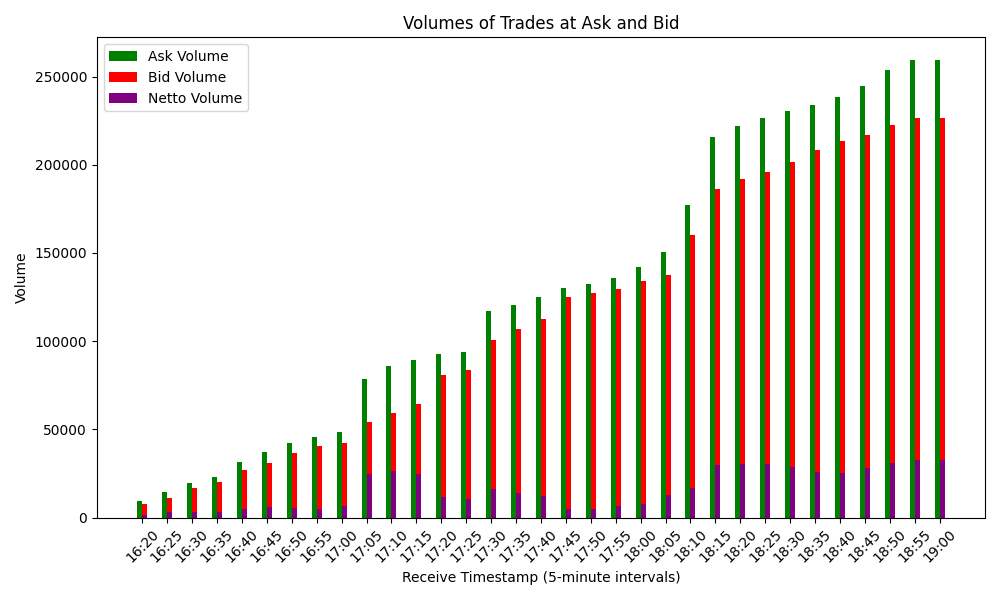

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ... [your filtering code here]

# Group by receive_timestamp in 5-minute intervals and sum the amount for ask trades
ask_volumes = ask_trades.resample('5T', on='receive_timestamp').sum().cumsum()['amount']

# Group by receive_timestamp in 5-minute intervals and sum the amount for bid trades
bid_volumes = bid_trades.resample('5T', on='receive_timestamp').sum().cumsum()['amount']

# Setting up the bar positions
bar_width = 0.2
index = np.arange(len(ask_volumes))

# Create the main figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Bar chart for ask trades
ax.bar(index, ask_volumes, bar_width, align='center', color='green', label='Ask Volume')

# Bar chart shifted to the right for bid trades
ax.bar(index + bar_width, bid_volumes, bar_width, align='center', color='red', label='Bid Volume')

ax.bar(index + bar_width, ask_volumes - bid_volumes, bar_width, align='center', color='purple', label='Netto Volume')

# Setting x-axis ticks and labels
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels([time.strftime('%H:%M') for time in ask_volumes.index.time], rotation=45)

ax.set_xlabel('Receive Timestamp (5-minute intervals)')
ax.set_ylabel('Volume')
ax.set_title('Volumes of Trades at Ask and Bid')
ax.legend()

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


In [10]:

binance_trades

,price,amount,maker_side,market_timestamp,receive_timestamp
5752,15.07,19.00,Bid,2023-06-13 01:00:01.579,2023-06-13 01:00:01.710
5753,15.07,0.67,Bid,2023-06-13 01:00:01.579,2023-06-13 01:00:01.710
5754,15.06,2.70,Bid,2023-06-13 01:00:04.437,2023-06-13 01:00:04.567
5755,15.06,1.59,Bid,2023-06-13 01:00:04.437,2023-06-13 01:00:04.568
5756,15.06,35.48,Bid,2023-06-13 01:00:04.437,2023-06-13 01:00:04.568
...,...,...,...,...,...
137274,15.01,0.49,Bid,2023-06-13 23:55:08.328,2023-06-13 23:55:08.459
137275,15.01,4.88,Ask,2023-06-13 23:55:10.445,2023-06-13 23:55:10.575
137276,15.01,0.73,Ask,2023-06-13 23:55:12.485,2023-06-13 23:55:12.614
137277,15.01,4.11,Ask,2023-06-13 23:55:13.533,2023-06-13 23:55:13.663


In [17]:

@jit(nopython=True)
def calculate_grid_values(prices, amounts, timestamps, grid_prices, r):
    n = len(prices)
    grid_len = len(grid_prices)
    grid_values_list = np.zeros((n, grid_len))

    previous_timestamp = timestamps[0]

    for i in range(n):
        current_tuple = np.zeros(grid_len)

        if i > 0:
            dt = (timestamps[i] - previous_timestamp) / (1000 * 3600)  # Convert to hours from milliseconds
            decay_factor = exp(-r * dt)

            # Apply the decay factor to the last tuple
            current_tuple = grid_values_list[i - 1] * decay_factor

        # Find the closest price index in the grid
        idx = np.searchsorted(grid_prices, prices[i])

        # Update the trade amount at the found index
        current_tuple[idx] += amounts[i]

        grid_values_list[i] = current_tuple

        # Update the previous timestamp
        previous_timestamp = timestamps[i]

    return grid_values_list

# Filter the trades
binance_trades_ask = binance_trades[binance_trades['maker_side'] == 'Ask']
binance_trades_bid = binance_trades[binance_trades['maker_side'] == 'Bid']

# Create a grid of prices
tick_size = 0.01
number_of_extra_ticks = 2
grid_start = binance_trades_ask['price'].min() - number_of_extra_ticks * tick_size
grid_end = binance_trades_ask['price'].max() + number_of_extra_ticks * tick_size
grid_prices = np.arange(grid_start, grid_end, tick_size)

# External constant
r = 0.9  # Adjust as needed

# Extract numpy arrays for prices, amounts, and timestamps
ask_prices = binance_trades_ask['price'].values
ask_amounts = binance_trades_ask['amount'].values
ask_timestamps = (pd.to_datetime(binance_trades_ask['market_timestamp']) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1ms')
ask_timestamps = ask_timestamps.values

# Calculate the grid values using the numba function
ask_grid_values_arr = calculate_grid_values(ask_prices, ask_amounts, ask_timestamps, grid_prices, r)

# Extract numpy arrays for prices, amounts, and timestamps
bid_prices = binance_trades_bid['price'].values
bid_amounts = binance_trades_bid['amount'].values
bid_timestamps = (pd.to_datetime(binance_trades_bid['market_timestamp']) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1ms')
bid_timestamps = bid_timestamps.values

# Calculate the grid values using the numba function
bid_grid_values_arr = calculate_grid_values(bid_prices, bid_amounts, bid_timestamps, grid_prices, r)


In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from google.colab import output
output.enable_custom_widget_manager()
%matplotlib widget

def draw(timestamps, grid_values_arr, side):
    plt.close('all')
    # Set up the figure and 3D axis
    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Use meshgrid to prepare the grid for the 3D plot
    timestamps_mesh, grid_prices_mesh = np.meshgrid(timestamps, grid_prices)

    # The Z values are taken from your grid_values_arr, but need to be transposed
    # to match the X, Y meshgrid
    Z = grid_values_arr.T

    # Plot the surface
    surf = ax.plot_surface(timestamps_mesh, grid_prices_mesh, Z, cmap='jet', alpha=0.65)

    # Extract best_ask and its corresponding timestamps for the line plot
    best_timestamps = (pd.to_datetime(binance['receive_timestamp']) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1ms')
    best_timestamps = best_timestamps.values
    best_prices = binance[side].values
    best_values = np.interp(best_prices, grid_prices, grid_values_arr[-1])  # Interpolating values for best_ask prices from the last tuple

    # Plot the best_ask as a wide red line
    ax.plot(best_timestamps, best_prices, best_values, color='red', linewidth=3, label=side)

    # Label the axes
    ax.set_xlabel('Market Timestamp')
    ax.set_ylabel('Price Level')
    ax.set_zlabel('Values')

    # Adjust x-axis ticks to match market_timestamp values from binance_trades_ask dataframe
    xticks_interval = len(timestamps) // 10
    ax.set_xticks(timestamps[::xticks_interval])  # Reducing the number of x-ticks for clarity
    labels = [(pd.Timestamp("1970-01-01") + pd.Timedelta(milliseconds=int(ts))).time().strftime('%H:%M:%S') for ts in timestamps[::xticks_interval]]
    ax.set_xticklabels(labels, rotation=45, ha='right')

    # Add a legend
    ax.legend()
    ax.set_title('Trade shadows')
    # Add a color bar for better visualization
    fig.colorbar(surf)

    plt.tight_layout()  # Adjust the layout
    plt.show()


<ipython-input-18-5632b397fbd3>:49: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Adjust the layout


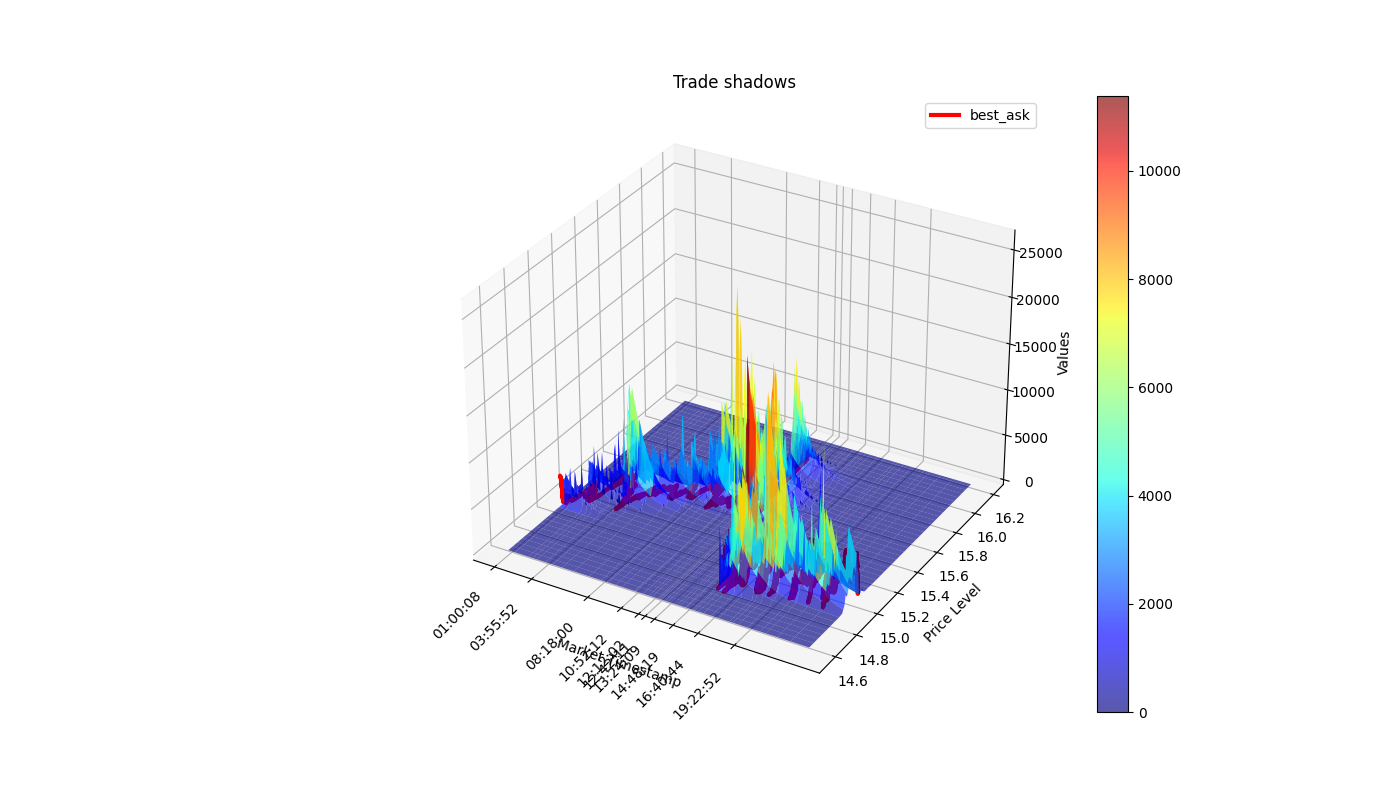

In [19]:
draw(ask_timestamps, ask_grid_values_arr, 'best_ask')

<ipython-input-18-5632b397fbd3>:49: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Adjust the layout


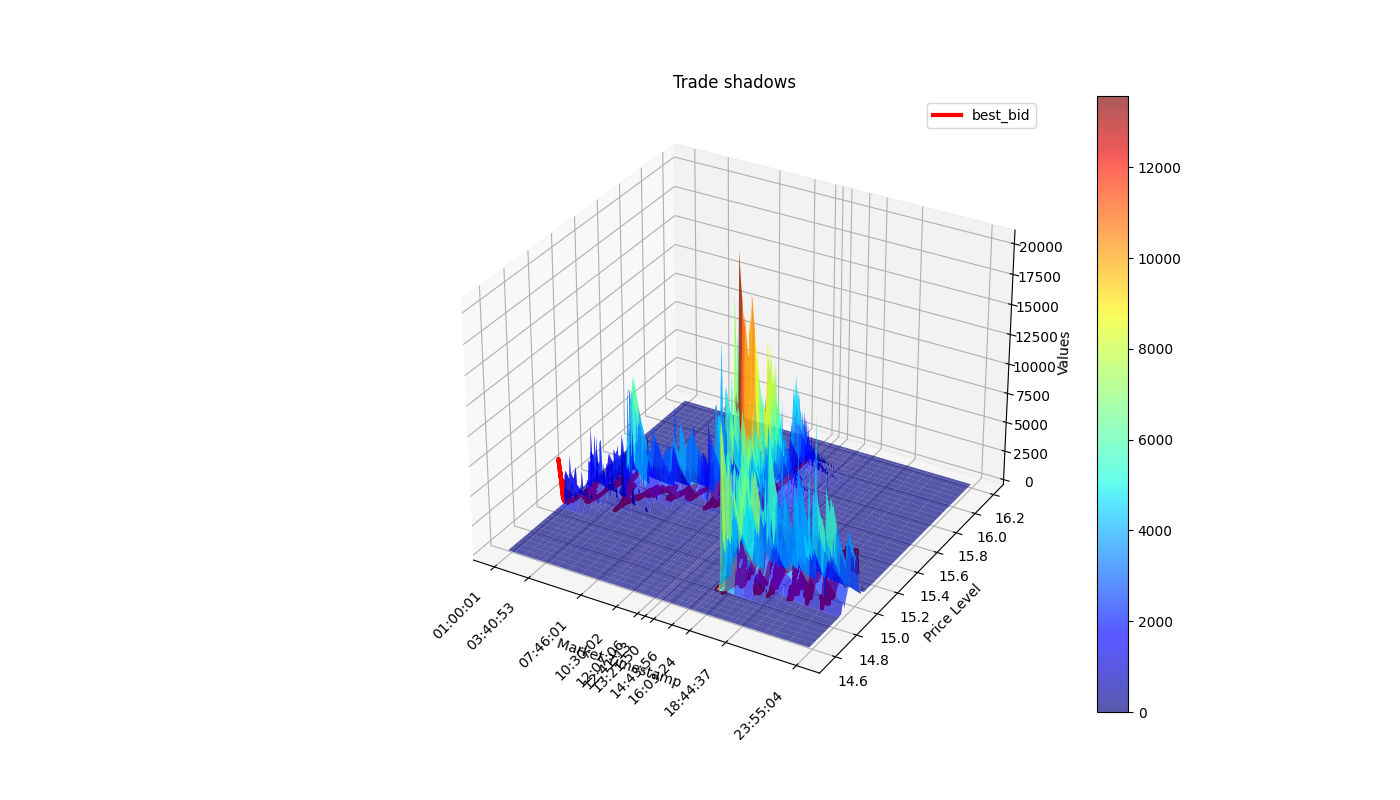

In [20]:
draw(bid_timestamps, bid_grid_values_arr, 'best_bid')

<ipython-input-18-5632b397fbd3>:49: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Adjust the layout


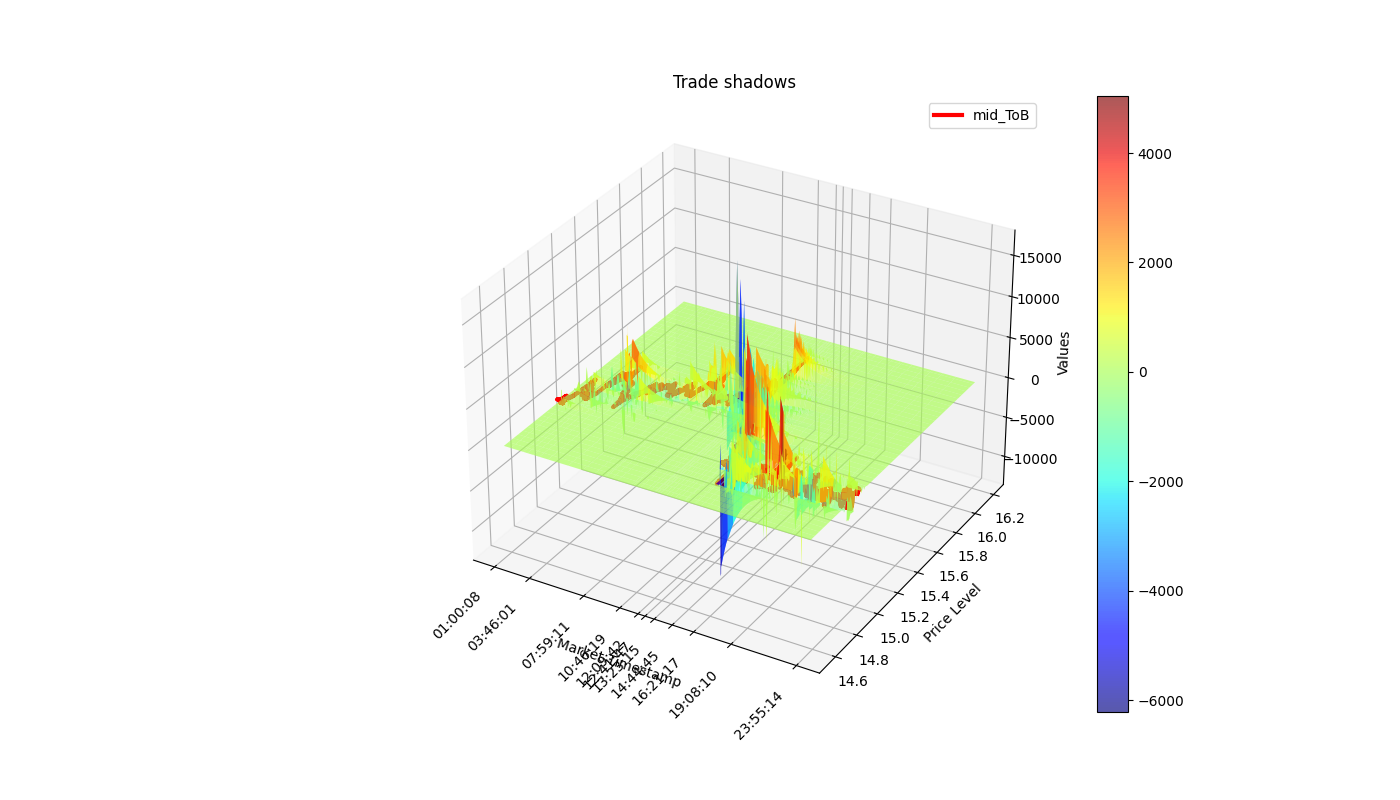

In [21]:
# Merge buy and sell timestamps and sort them
timestamps = np.sort(np.concatenate((ask_timestamps, bid_timestamps)))

# Find the indices in sell timestamps corresponding to each buy timestamp
sell_indices = np.searchsorted(ask_timestamps, bid_timestamps)

# Initialize an array to store the merged data
merged_data = np.full((len(timestamps), ask_grid_values_arr.shape[1] + bid_grid_values_arr.shape[1]), np.nan)

# Merge buy data into the merged_data array
merged_data[np.searchsorted(timestamps, ask_timestamps), :ask_grid_values_arr.shape[1]] = ask_grid_values_arr

# Merge sell data into the merged_data array
merged_data[np.searchsorted(timestamps, bid_timestamps), ask_grid_values_arr.shape[1]:] = bid_grid_values_arr

# Use forward fill to fill NaN values with the last available data in each column independently
for i in range(1, len(merged_data)):
    for j in range(merged_data.shape[1]):
        if np.isnan(merged_data[i, j]):
            merged_data[i, j] = merged_data[i - 1, j]

# Remove rows with NaN values and update corresponding timestamps list
non_nan_indices = ~np.isnan(merged_data).any(axis=1)
merged_data = merged_data[non_nan_indices]
diff_timestamps = timestamps[non_nan_indices]

# Calculate the differences between the (i + shape[1]) and i columns
diff_grid_values_arr = merged_data[:, :ask_grid_values_arr.shape[1]] - merged_data[:, ask_grid_values_arr.shape[1]:]

draw(diff_timestamps, diff_grid_values_arr, 'mid_ToB')


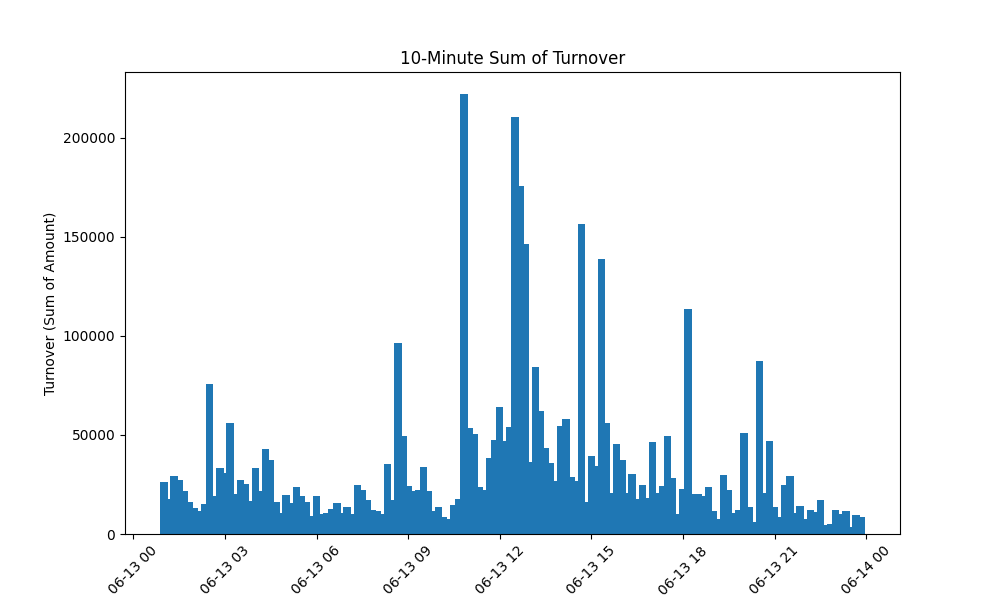

In [24]:

import pandas as pd
import matplotlib.pyplot as plt


# Resample data into 10-minute intervals and calculate the sum of turnover
turnover_10min = binance_trades['amount'].resample('10T').sum()

# Set a larger figure size
plt.figure(figsize=(10, 6))

# Create a bar chart for 10-minute sum of turnover
plt.bar(turnover_10min.index, turnover_10min.values, width=0.01)
plt.xlabel('Receive Timestamp (10-Minute Intervals)')
plt.ylabel('Turnover (Sum of Amount)')
plt.title('10-Minute Sum of Turnover')
plt.xticks(rotation=45)

plt.show()


In [23]:
binance_trades

,price,amount,maker_side,market_timestamp
receive_timestamp,,,,
2023-06-13 01:00:01.710,15.07,19.00,Bid,2023-06-13 01:00:01.579
2023-06-13 01:00:01.710,15.07,0.67,Bid,2023-06-13 01:00:01.579
2023-06-13 01:00:04.567,15.06,2.70,Bid,2023-06-13 01:00:04.437
2023-06-13 01:00:04.568,15.06,1.59,Bid,2023-06-13 01:00:04.437
2023-06-13 01:00:04.568,15.06,35.48,Bid,2023-06-13 01:00:04.437
...,...,...,...,...
2023-06-13 23:55:08.459,15.01,0.49,Bid,2023-06-13 23:55:08.328
2023-06-13 23:55:10.575,15.01,4.88,Ask,2023-06-13 23:55:10.445
2023-06-13 23:55:12.614,15.01,0.73,Ask,2023-06-13 23:55:12.485


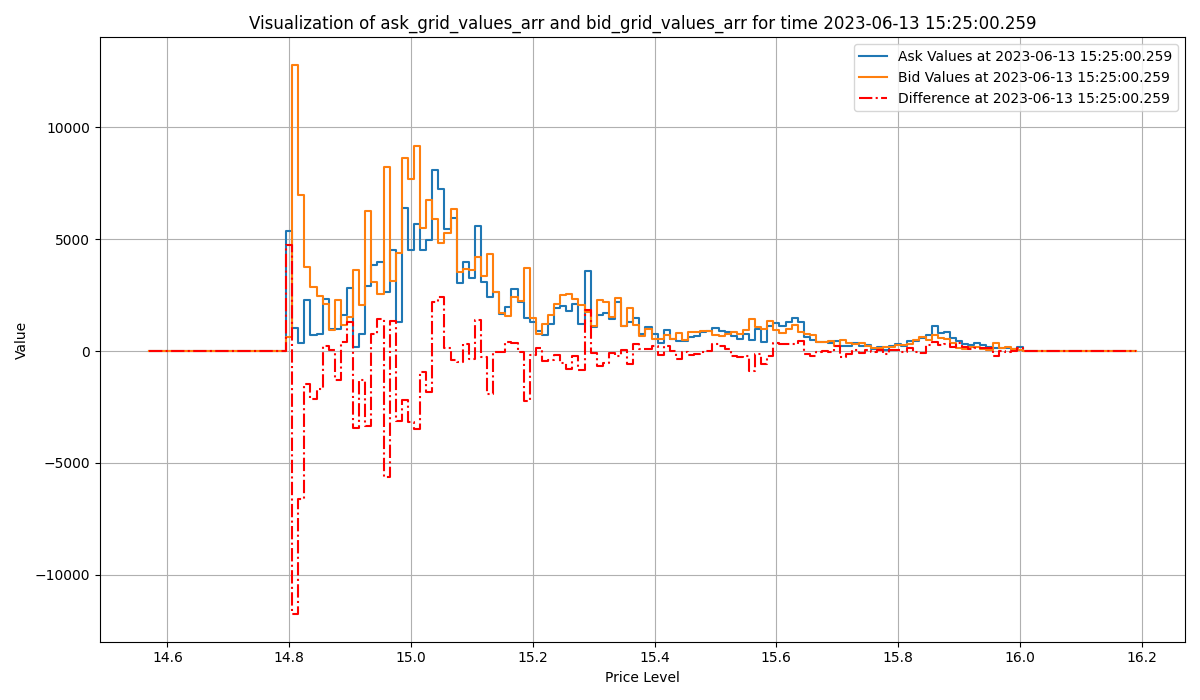

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Convert the given time to timestamp format
given_time = '2023-06-13 15:25:00.259'
timestamp_format = (pd.to_datetime(given_time) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1ms')

# Find the index of the closest timestamp that's less than or equal to the given time for ASK
ask_idx = np.searchsorted(ask_timestamps, timestamp_format, side='right') - 1  # -1 because we want the last available timestamp

# Fetch the corresponding row from ask_grid_values_arr
ask_values = ask_grid_values_arr[ask_idx]

# Find the index of the closest timestamp that's less than or equal to the given time for BID
bid_idx = np.searchsorted(bid_timestamps, timestamp_format, side='right') - 1  # -1 because we want the last available timestamp

# Fetch the corresponding row from bid_grid_values_arr
bid_values = bid_grid_values_arr[bid_idx]

# Calculate the difference between ask and bid values
difference_values = ask_values - bid_values

# Plotting
plt.figure(figsize=(12, 7))

# Using step plot
plt.step(grid_prices, ask_values, where='mid', label=f"Ask Values at {given_time}")
plt.step(grid_prices, bid_values, where='mid', label=f"Bid Values at {given_time}")  # dashed line for distinction
plt.step(grid_prices, difference_values, where='mid', label=f"Difference at {given_time}", linestyle='-.', color='red')  # dash-dot line for distinction

plt.xlabel('Price Level')
plt.ylabel('Value')
plt.title(f"Visualization of ask_grid_values_arr and bid_grid_values_arr for time {given_time}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [44]:
ask_timestamps

array([1686618008729, 1686618008729, 1686618008729, ..., 1686700512485,
       1686700513533, 1686700514410])